# Evaluation of the parametrised model

In [23]:
from adjustText import adjust_text
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

from modules import stats


In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35151,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:41291,Total threads: 1
Dashboard: http://127.0.0.1:44427/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:44683,


In [3]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/05_evaluation/'
data_path = base_path + 'final_data/evaluation/'
config_file = base_path + 'config/evaluation.yml'

with open(config_file, 'r') as f:
    config = yaml.load(f, yaml.Loader)

RAYLEIGH = config['truth']['parameters']['rayleigh']
PRANDTL = config['truth']['parameters']['prandtl']


## Long-term statistics (comparing to coarse-grained truth)

In [62]:
COARSE_SPIN_UP_TIME = 800.
AVG_TIME = 150.


In [63]:
data = {}
chunks = {'x': -1, 'z': -1, 't': 800}
data['truth'] = xr.open_mfdataset(
    data_path + 'coarse_grained/*.nc', chunks=chunks,
)

data['control'] = xr.open_mfdataset(
    data_path + 'control/*.nc', chunks=chunks,
)
data['control'] = data['control'].isel(
    t=(data['control'].t >= COARSE_SPIN_UP_TIME))

data['test'] = xr.open_mfdataset(
    data_path + 'parametrised/*.nc', chunks=chunks,
)
data['test'] = data['test'].isel(
    t=(data['test'].t >= COARSE_SPIN_UP_TIME))


In [64]:
nusselt = {}
thermal_bl = {}
rms_speed = {}
eps_k = {}
eps_T = {}
for run in data:
    nusselt[run] = stats.nusselt_number(
        data[run], RAYLEIGH, PRANDTL).compute()
    thermal_bl[run] = stats.thermal_bl_thickness(data[run])
    rms_speed[run] = stats.rms_speed(data[run]).compute()
    eps_k[run] = stats.kinetic_dissipation(
        data[run], RAYLEIGH, PRANDTL).compute()
    eps_T[run] = stats.thermal_dissipation(
        data[run], RAYLEIGH, PRANDTL).compute()


In [65]:
metrics = {
    r'$\mathrm{Nu}$': nusselt,
    r'$\delta_\theta$': thermal_bl,
    r'$u_\mathrm{rms}$': rms_speed,
    r'$\epsilon_k$': eps_k,
    r'$\epsilon_\theta$': eps_T,
}


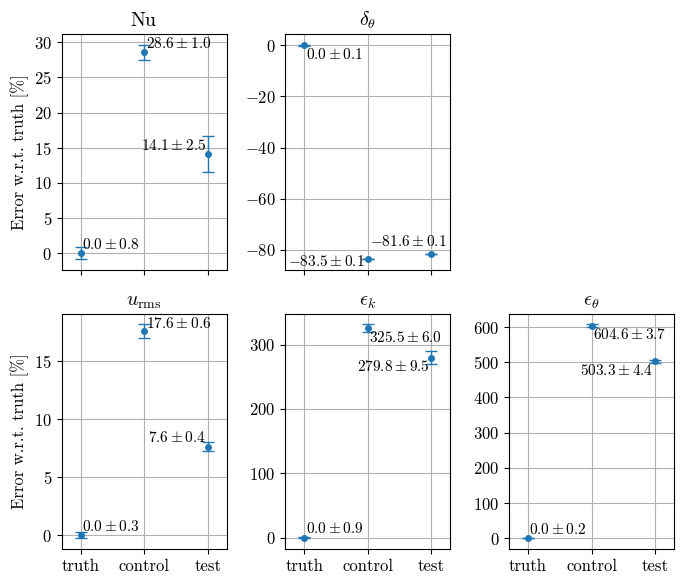

In [69]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(7, 6))

plot_axes = [*axes[0,:-1].ravel(), *axes[1,:].ravel()]
for ax, (name, var) in zip(plot_axes, metrics.items()):
    mean_truth, delta_truth = stats.mean_and_uncertainty(
        var['truth'], 't', AVG_TIME,
    )
    means = []
    deltas = []
    texts = []
    for i, run in enumerate(var.keys()):
        mean, delta = stats.mean_and_uncertainty(var[run], 't', AVG_TIME)
        means.append((mean/mean_truth - 1)*100)
        deltas.append(delta/mean_truth*100)
        text = f'${means[i]:.1f} \\pm {deltas[i]:.1f}$'
        texts.append(ax.text(i, means[i], text, fontsize=11, va='bottom'))

    ax.errorbar(
        list(var.keys()), means, yerr=deltas,
        capsize=4, elinewidth=1, marker='.', linestyle='',
        capthick=1, markersize=8,
    )
    ax.set_title(name)
    ax.set_xlim(-0.3, 2.3)
    ax.grid()
    adjust_text(texts, ax=ax)

fig.delaxes(axes[0,-1])
# for ax in axes[-1,:]: ax.set_xlabel('Simulation')

for ax in axes[:,0]: ax.set_ylabel(
    f'Error w.r.t. truth [%]')

fig.tight_layout()
fig.savefig(fig_path + 'stats.pdf')


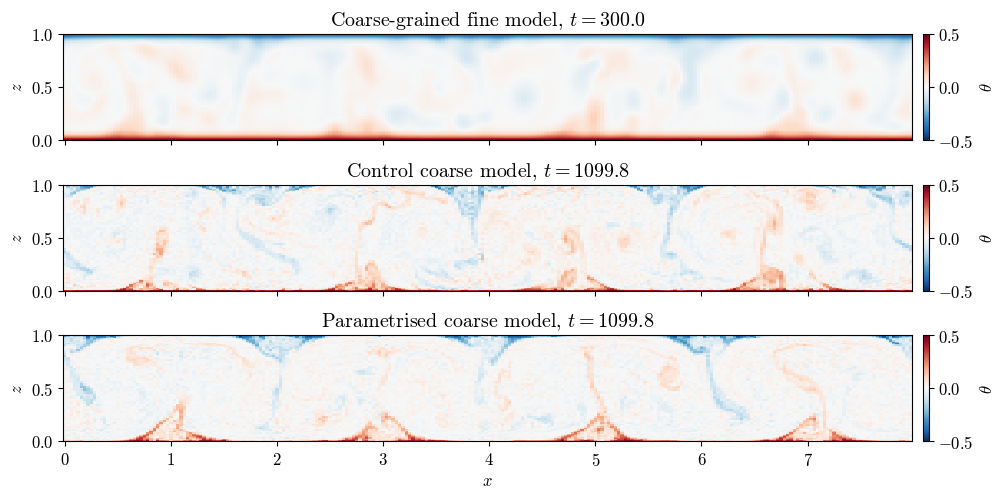

In [77]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 5))

theta = data['truth'].theta.isel(t=-1)
mesh = axes[0].pcolormesh(
    theta.x, theta.z, theta.T, cmap='RdBu_r', vmin=-0.5, vmax=0.5,
)
fig.colorbar(mesh, ax=axes[0], label='$\\theta$', pad=0.01)
axes[0].set_title(f'Coarse-grained fine model, $t = {theta.t:.1f}$')

theta = data['control'].theta.isel(t=-1)
mesh = axes[1].pcolormesh(
    theta.x, theta.z, theta.T, cmap='RdBu_r', vmin=-0.5, vmax=0.5,
)
fig.colorbar(mesh, ax=axes[1], label='$\\theta$', pad=0.01)
axes[1].set_title(f'Control coarse model, $t = {theta.t:.1f}$')

theta = data['test'].theta.isel(t=-1)
mesh = axes[2].pcolormesh(
    theta.x, theta.z, theta.T, cmap='RdBu_r', vmin=-0.5, vmax=0.5,
)
fig.colorbar(mesh, ax=axes[2], label='$\\theta$', pad=0.01)
axes[2].set_title(f'Parametrised coarse model, $t = {theta.t:.1f}$')
axes[2].set_xlabel('$x$')

for ax in axes:
    ax.set(aspect='equal', ylabel='$z$')
fig.tight_layout()
fig.savefig(fig_path + 'steady_state_vis.pdf')


## Long-term statistics (comparing to raw truth)

In [10]:
COARSE_SPIN_UP_TIME = 800.
AVG_TIME = 150.


In [11]:
data = {}
data['truth'] = xr.open_mfdataset(
    data_path + 'truth/*.nc', chunks={'x': -1, 'z': -1, 't': 25},
)

chunks = {'x': -1, 'z': -1, 't': 800}
data['control'] = xr.open_mfdataset(
    data_path + 'control/*.nc', chunks=chunks,
)
data['control'] = data['control'].isel(
    t=(data['control'].t >= COARSE_SPIN_UP_TIME))

data['test'] = xr.open_mfdataset(
    data_path + 'parametrised/*.nc', chunks=chunks,
)
data['test'] = data['test'].isel(
    t=(data['test'].t >= COARSE_SPIN_UP_TIME))


In [14]:
nusselt = {}
thermal_bl = {}
rms_speed = {}
eps_k = {}
eps_T = {}
for run in data:
    nusselt[run] = stats.nusselt_number(
        data[run], RAYLEIGH, PRANDTL).compute()
    thermal_bl[run] = stats.thermal_bl_thickness(data[run])
    rms_speed[run] = stats.rms_speed(data[run]).compute()
    eps_k[run] = stats.kinetic_dissipation(
        data[run], RAYLEIGH, PRANDTL).compute()
    eps_T[run] = stats.thermal_dissipation(
        data[run], RAYLEIGH, PRANDTL).compute()


In [15]:
metrics = {
    r'$\mathrm{Nu}$': nusselt,
    r'$\delta_\theta$': thermal_bl,
    r'$u_\mathrm{rms}$': rms_speed,
    r'$\epsilon_k$': eps_k,
    r'$\epsilon_\theta$': eps_T,
}


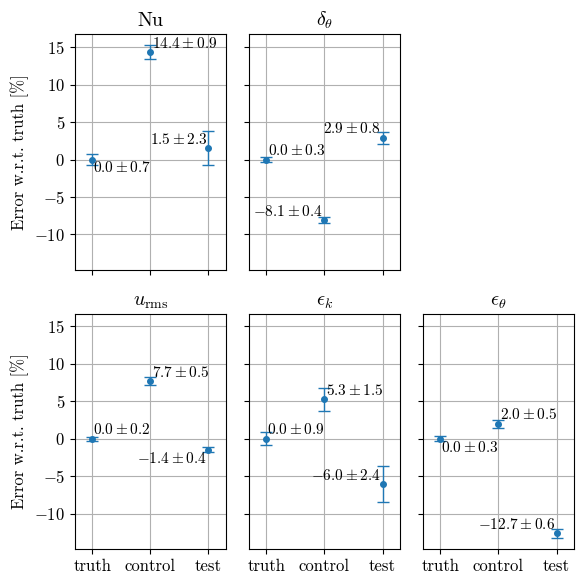

In [61]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(6, 6))

plot_axes = [*axes[0,:-1].ravel(), *axes[1,:].ravel()]
for ax, (name, var) in zip(plot_axes, metrics.items()):
    mean_truth, delta_truth = stats.mean_and_uncertainty(
        var['truth'], 't', AVG_TIME,
    )
    means = []
    deltas = []
    texts = []
    for i, run in enumerate(var.keys()):
        mean, delta = stats.mean_and_uncertainty(var[run], 't', AVG_TIME)
        means.append((mean/mean_truth - 1)*100)
        deltas.append(delta/mean_truth*100)
        text = f'${means[i]:.1f} \\pm {deltas[i]:.1f}$'
        texts.append(ax.text(i, means[i], text, fontsize=11, va='bottom'))

    ax.errorbar(
        list(var.keys()), means, yerr=deltas,
        capsize=4, elinewidth=1, marker='.', linestyle='',
        capthick=1, markersize=8,
    )
    ax.set_title(name)
    ax.set_xlim(-0.3, 2.3)
    ax.grid()
    adjust_text(texts, ax=ax)

fig.delaxes(axes[0,-1])
# for ax in axes[-1,:]: ax.set_xlabel('Simulation')

for ax in axes[:,0]: ax.set_ylabel(
    f'Error w.r.t. truth [%]')

fig.tight_layout()
fig.savefig(fig_path + 'stats_vs_fine.pdf')


In [78]:
client.close()
